In [1]:
%load_ext watermark
%watermark -p torch,pytorch_lightning,torchmetrics,matplotlib

torch            : 1.10.1
pytorch_lightning: 1.5.10
torchmetrics     : 0.6.2
matplotlib       : 3.3.4



In [2]:
%load_ext pycodestyle_magic
%flake8_on --ignore W291,W293,E703

<a href="https://pytorch.org"><img src="https://raw.githubusercontent.com/pytorch/pytorch/master/docs/source/_static/img/pytorch-logo-dark.svg" width="90"/></a> &nbsp; &nbsp;&nbsp;&nbsp;<a href="https://www.pytorchlightning.ai"><img src="https://raw.githubusercontent.com/PyTorchLightning/pytorch-lightning/master/docs/source/_static/images/logo.svg" width="150"/></a>

# Model Zoo -- DenseNet121 Trained on CIFAR-10

### Network Architecture

The network in this notebook is an implementation of the DenseNet-121 [1] architecture on the MNIST digits dataset (http://yann.lecun.com/exdb/mnist/) to train a handwritten digit classifier.  


The following figure illustrates the main concept of DenseNet: within each "dense" block, each layer is connected with each previous layer -- the feature maps are concatenated.


![](../../pytorch_ipynb/images/densenet/densenet-fig-2.jpg)

Note that this is somewhat related yet very different to ResNets. ResNets have skip connections approx. between every other layer (but don't connect all layers with each other). Also, ResNets skip connections work via addition

$$\mathbf{x}_{\ell}=H_{\ell}\left(\mathbf{X}_{\ell-1}\right)+\mathbf{X}_{\ell-1}$$,

whereas $H_{\ell}(\cdot)$ can be a composite function  of operations such as Batch Normalization (BN), rectified linear units (ReLU), Pooling, or Convolution (Conv).

In DenseNets, all the previous feature maps $\mathbf{X}_{0}, \dots, \mathbf{X}_{\ell}-1$ of a feature map $\mathbf{X}_{\ell}$ are concatenated:

$$\mathbf{x}_{\ell}=H_{\ell}\left(\left[\mathbf{x}_{0}, \mathbf{x}_{1}, \ldots, \mathbf{x}_{\ell-1}\right]\right).$$

Furthermore, in this particular notebook, we are considering the DenseNet-121, which is depicted below:



![](../../pytorch_ipynb/images/densenet/densenet-tab-1-dnet121.jpg)

**References**
    
- [1] Huang, G., Liu, Z., Van Der Maaten, L., & Weinberger, K. Q. (2017). Densely connected convolutional networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4700-4708), http://openaccess.thecvf.com/content_cvpr_2017/html/Huang_Densely_Connected_Convolutional_CVPR_2017_paper.html

- [2] http://yann.lecun.com/exdb/mnist/

## General settings and hyperparameters

- Here, we specify some general hyperparameter values and general settings
- Note that for small datatsets, it is not necessary and better not to use multiple workers as it can sometimes cause issues with too many open files in PyTorch. So, if you have problems with the data loader later, try setting `NUM_WORKERS = 0` instead.

In [3]:
BATCH_SIZE = 256
NUM_EPOCHS = 20
LEARNING_RATE = 0.005
NUM_WORKERS = 4

## Implementing a Neural Network using PyTorch Lightning's `LightningModule`

- In this section, we set up the main model architecture using the `LightningModule` from PyTorch Lightning.
- We start with defining our neural network  model in pure PyTorch, and then we use it in the `LightningModule` to get all the extra benefits that PyTorch Lightning provides.

In [4]:
##########################
### MODEL
##########################

# The following code cell that implements the DenseNet-121 architecture 
# is a derivative of the code provided at 
# https://github.com/pytorch/vision/blob/master/torchvision/models/densenet.py

import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from collections import OrderedDict



def _bn_function_factory(norm, relu, conv):
    def bn_function(*inputs):
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = conv(relu(norm(concated_features)))
        return bottleneck_output

    return bn_function


class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate,
                 bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.ReLU(inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.ReLU(inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = drop_rate
        self.memory_efficient = memory_efficient

    def forward(self, *prev_features):
        bn_function = _bn_function_factory(self.norm1, self.relu1, self.conv1)
        if self.memory_efficient and any(
                prev_feature.requires_grad for 
                prev_feature in prev_features):
            bottleneck_output = cp.checkpoint(bn_function, *prev_features)
        else:
            bottleneck_output = bn_function(*prev_features)
        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features


class _DenseBlock(nn.Module):
    def __init__(self, num_layers, num_input_features, 
                 bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module('denselayer%d' % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.named_children():
            new_features = layer(*features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(
            num_input_features, num_output_features,
            kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))


class PyTorchDenseNet121(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks"
    <https://arxiv.org/pdf/1608.06993.pdf>`_

    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_featuremaps (int) - the number of filters to learn in the 
        first convolution layer bn_size (int) - multiplicative factor for 
        number of bottle neck layers (i.e. bn_size * k features 
        in the bottleneck layer) drop_rate (float) - dropout rate after 
        each dense layer num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. 
        Much more memory efficient, but slower. Default: *False*. 
        See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """

    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_featuremaps=64, bn_size=4, drop_rate=0, 
                 num_classes=1000, memory_efficient=False,
                 grayscale=False):

        super().__init__()

        # First convolution
        if grayscale:
            in_channels=1
        else:
            in_channels=3
        
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(
                in_channels=in_channels,
                out_channels=num_init_featuremaps,
                kernel_size=7,
                stride=2,
                padding=3,
                bias=False)), # bias is redundant when using batchnorm
            ('norm0', nn.BatchNorm2d(num_features=num_init_featuremaps)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_featuremaps
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        logits = self.classifier(out)
        return logits

2:1: E266 too many leading '#' for block comment
18:1: E303 too many blank lines (3)
34:80: E501 line too long (80 > 79 characters)
119:24: E225 missing whitespace around operator
121:24: E225 missing whitespace around operator
130:30: E261 at least two spaces before inline comment


In [5]:
import pytorch_lightning as pl
import torchmetrics


# LightningModule that receives a PyTorch model as input
class LightningModel(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        # The inherited PyTorch module
        self.model = model

        # Save settings and hyperparameters to the log directory
        # but skip the model parameters
        self.save_hyperparameters(ignore=['model'])

        # Set up attributes for computing the accuracy
        self.train_acc = torchmetrics.Accuracy()
        self.valid_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()
        
    # Defining the forward method is only necessary 
    # if you want to use a Trainer's .predict() method (optional)
    def forward(self, x):
        return self.model(x)
        
    # A common forward step to compute the loss and labels
    # this is used for training, validation, and testing below
    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)
        loss = torch.nn.functional.cross_entropy(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)

        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss)
        
        # To account for Dropout behavior during evaluation
        self.model.eval()
        with torch.no_grad():
            _, true_labels, predicted_labels = self._shared_step(batch)
        self.train_acc.update(predicted_labels, true_labels)
        self.log("train_acc", self.train_acc, on_epoch=True, on_step=False)
        self.model.train()
        return loss  # this is passed to the optimzer for training

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_acc(predicted_labels, true_labels)
        self.log("valid_acc", self.valid_acc,
                 on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_acc(predicted_labels, true_labels)
        self.log("test_acc", self.test_acc, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

## Setting up the dataset

- In this section, we are going to set up our dataset.

### Inspecting the dataset

In [6]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader


train_dataset = datasets.CIFAR10(root='./data', 
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          num_workers=NUM_WORKERS,
                          drop_last=True,
                          shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', 
                                train=False,
                                transform=transforms.ToTensor())

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         drop_last=False,
                         shuffle=False)

# Checking the dataset
all_train_labels = []
all_test_labels = []

for images, labels in train_loader:  
    all_train_labels.append(labels)
all_train_labels = torch.cat(all_train_labels)
    
for images, labels in test_loader:  
    all_test_labels.append(labels)
all_test_labels = torch.cat(all_test_labels)

Files already downloaded and verified


In [7]:
print('Training labels:', torch.unique(all_train_labels))
print('Training label distribution:', torch.bincount(all_train_labels))

print('\nTest labels:', torch.unique(all_test_labels))
print('Test label distribution:', torch.bincount(all_test_labels))

Training labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Training label distribution: tensor([4989, 4993, 4993, 4996, 4991, 4988, 4989, 4992, 4998, 4991])

Test labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Test label distribution: tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])


### Performance baseline

- Especially for imbalanced datasets, it's quite useful to compute a performance baseline.
- In classification contexts, a useful baseline is to compute the accuracy for a scenario where the model always predicts the majority class -- you want your model to be better than that!

In [8]:
majority_prediction = torch.argmax(torch.bincount(all_test_labels))
baseline_acc = torch.mean((all_test_labels == majority_prediction).float())
print(f'Baseline ACC: {baseline_acc*100:.2f}%')

Baseline ACC: 10.00%


### Setting up a `DataModule`

- There are three main ways we can prepare the dataset for Lightning. We can
  1. make the dataset part of the model;
  2. set up the data loaders as usual and feed them to the fit method of a Lightning Trainer -- the Trainer is introduced in the next subsection;
  3. create a LightningDataModule.
- Here, we are going to use approach 3, which is the most organized approach. The `LightningDataModule` consists of several self-explanatory methods as we can see below:


In [9]:
import os

from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torchvision import transforms


class DataModule(pl.LightningDataModule):
    def __init__(self, data_path='./'):
        super().__init__()
        self.data_path = data_path
        
    def prepare_data(self):
        datasets.CIFAR10(root=self.data_path,
                         download=True)
        
        self.train_transform = transforms.Compose(
            [transforms.Resize((70, 70)),
             transforms.RandomCrop((64, 64)),
             transforms.ToTensor()])

        self.test_transform = transforms.Compose(
            [transforms.Resize((70, 70)),
             transforms.CenterCrop((64, 64)),
             transforms.ToTensor()])
        return

    def setup(self, stage=None):
        train = datasets.CIFAR10(root=self.data_path, 
                                 train=True, 
                                 transform=self.train_transform,
                                 download=False)

        self.test = datasets.CIFAR10(root=self.data_path, 
                                     train=False, 
                                     transform=self.test_transform,
                                     download=False)

        self.train, self.valid = random_split(train, lengths=[45000, 5000])

    def train_dataloader(self):
        train_loader = DataLoader(dataset=self.train, 
                                  batch_size=BATCH_SIZE, 
                                  drop_last=True,
                                  shuffle=True,
                                  num_workers=NUM_WORKERS)
        return train_loader

    def val_dataloader(self):
        valid_loader = DataLoader(dataset=self.valid, 
                                  batch_size=BATCH_SIZE, 
                                  drop_last=False,
                                  shuffle=False,
                                  num_workers=NUM_WORKERS)
        return valid_loader

    def test_dataloader(self):
        test_loader = DataLoader(dataset=self.test, 
                                 batch_size=BATCH_SIZE, 
                                 drop_last=False,
                                 shuffle=False,
                                 num_workers=NUM_WORKERS)
        return test_loader

- Note that the `prepare_data` method is usually used for steps that only need to be executed once, for example, downloading the dataset; the `setup` method defines the the dataset loading -- if you run your code in a distributed setting, this will be called on each node / GPU. 
- Next, lets initialize the `DataModule`; we use a random seed for reproducibility (so that the data set is shuffled the same way when we re-execute this code):

In [10]:
torch.manual_seed(1) 
data_module = DataModule(data_path='./data')

## Training the model using the PyTorch Lightning Trainer class

- Next, we initialize our model.
- Also, we define a call back so that we can obtain the model with the best validation set performance after training.
- PyTorch Lightning offers [many advanced logging services](https://pytorch-lightning.readthedocs.io/en/latest/extensions/logging.html) like Weights & Biases. Here, we will keep things simple and use the `CSVLogger`:

In [11]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger


pytorch_model = PyTorchDenseNet121()

lightning_model = LightningModel(
    pytorch_model, learning_rate=LEARNING_RATE)

callbacks = [ModelCheckpoint(
    save_top_k=1, mode='max', monitor="valid_acc")]  # save top 1 model 
logger = CSVLogger(save_dir="logs/", name="my-model")

- Now it's time to train our model:

In [12]:
import time


trainer = pl.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=callbacks,
    progress_bar_refresh_rate=50,  # recommended for notebooks
    accelerator="auto",  # Uses GPUs or TPUs if available
    devices="auto",  # Uses all available GPUs/TPUs if applicable
    logger=logger,
    log_every_n_steps=100)

start_time = time.time()
trainer.fit(model=lightning_model, datamodule=data_module)

runtime = (time.time() - start_time)/60
print(f"Training took {runtime:.2f} min in total.")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | PyTorchDenseNet121 | 8.0 M 
1 | train_acc | Accuracy           | 0     
2 | valid_acc | Accuracy           | 0     
3 | test_acc  | Accuracy           | 0     
-------------------------------------------------
8.0 M     Trainable params
0         Non-trainable params
8.0 M     Total params
31.915    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Training took 10.76 min in total.


## Evaluating the model

- After training, let's plot our training ACC and validation ACC using pandas, which, in turn, uses matplotlib for plotting (you may want to consider a [more advanced logger](https://pytorch-lightning.readthedocs.io/en/latest/extensions/logging.html) that does that for you):

<AxesSubplot:xlabel='Epoch', ylabel='ACC'>

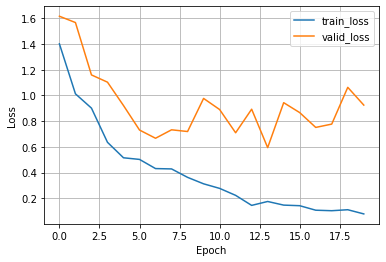

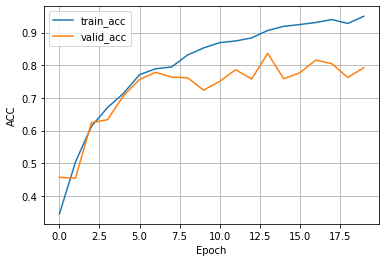

In [13]:
import pandas as pd


metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='Loss')
df_metrics[["train_acc", "valid_acc"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='ACC')

- The `trainer` automatically saves the model with the best validation accuracy automatically for us, we which we can load from the checkpoint via the `ckpt_path='best'` argument; below we use the `trainer` instance to evaluate the best model on the test set:

In [14]:
trainer.test(model=lightning_model, datamodule=data_module, ckpt_path='best')

Restoring states from the checkpoint path at logs/my-model/version_14/checkpoints/epoch=13-step=2449.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at logs/my-model/version_14/checkpoints/epoch=13-step=2449.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8392000198364258}
--------------------------------------------------------------------------------


[{'test_acc': 0.8392000198364258}]

## Predicting labels of new data

- You can use the `trainer.predict` method on a new `DataLoader` or `DataModule` to apply the model to new data.
- Alternatively, you can also manually load the best model from a checkpoint as shown below:

In [15]:
path = trainer.checkpoint_callback.best_model_path
print(path)

logs/my-model/version_14/checkpoints/epoch=13-step=2449.ckpt


In [16]:
lightning_model = LightningModel.load_from_checkpoint(
    path, model=pytorch_model)
lightning_model.eval();

- Note that our PyTorch model, which is passed to the Lightning model requires input arguments. However, this is automatically being taken care of since we used `self.save_hyperparameters()` in our PyTorch model's `__init__` method.
- Now, below is an example applying the model manually. Here, pretend that the `test_dataloader` is a new data loader.

In [17]:
test_dataloader = data_module.test_dataloader()

all_true_labels = []
all_predicted_labels = []
for batch in test_dataloader:
    features, labels = batch
    
    with torch.no_grad():  # since we don't need to backprop
        logits = lightning_model(features)
    
    predicted_labels = torch.argmax(logits, dim=1)
    all_predicted_labels.append(predicted_labels)
    all_true_labels.append(labels)
    
all_predicted_labels = torch.cat(all_predicted_labels)
all_true_labels = torch.cat(all_true_labels)
all_predicted_labels[:5]

tensor([3, 8, 8, 0, 6])

Just as an internal check, if the model was loaded correctly, the test accuracy below should be identical to the test accuracy we saw earlier in the previous section.

In [18]:
test_acc = torch.mean((all_predicted_labels == all_true_labels).float())
print(f'Test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')

Test accuracy: 0.8392 (83.92%)
